### Imports

In [ ]:
from IPython.display import Image, display

# Overall view

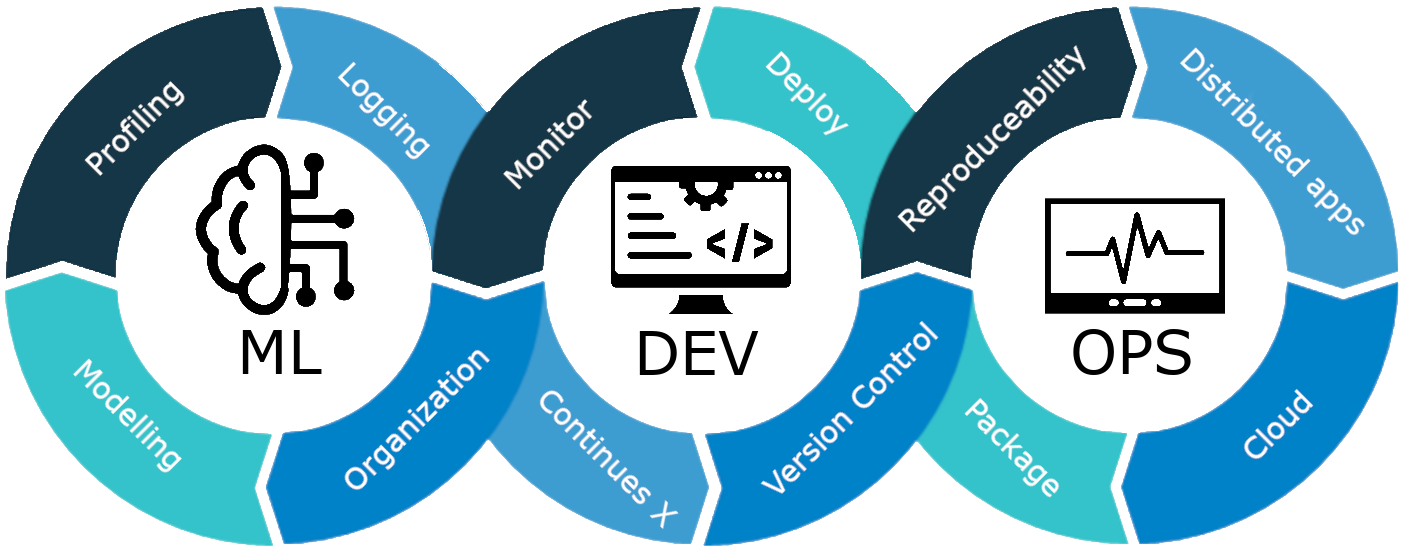

In [ ]:
file = '../img/what-is-mlops.png'
display(Image(filename=file, embed=True, width=1000, height=800))

### Deeper View

![image.png](attachment:image.png)

# Important tool definitions [Must Read]

## Helm

[Helm](https://helm.sh/) is a package manager for Kubernetes applications. It simplifies the deployment and management of Kubernetes applications by defining, installing, and upgrading even the most complex Kubernetes applications. Helm uses charts, which are packages of pre-configured Kubernetes resources.

## Istio

[Istio](https://istio.io/) is an open-source service mesh that helps manage and secure microservices-based applications. It provides features such as traffic management, load balancing, security, and observability. Istio is often used to enhance the capabilities of Kubernetes clusters, offering additional control and visibility into the communication between services.

## Kustomize

[Kustomize](https://kustomize.io/) is a tool for customizing Kubernetes manifests. It allows you to manage and customize Kubernetes resources without modifying the original YAML files directly. Kustomize is often used in conjunction with Helm or as an alternative for configuration management in Kubernetes.

## Minikube

[Minikube](https://minikube.sigs.k8s.io/) is a tool for running local Kubernetes clusters on a single machine. It allows developers to set up and test Kubernetes clusters locally, providing a lightweight and isolated environment for testing Kubernetes configurations and applications. Minikube is an alternative to Kind for local Kubernetes development.

## Prometheus

[Prometheus](https://prometheus.io/) is an open-source monitoring and alerting toolkit designed for reliability and scalability in dynamic environments. It is particularly well-suited for monitoring Kubernetes and containerized applications. Prometheus collects metrics from configured targets at specified intervals, stores them, and allows for querying and alerting based on those metrics.

## Seldon Core

[Seldon Core](https://www.seldon.io/tech/products/core/) is an open-source platform for deploying machine learning models on Kubernetes. It facilitates the deployment, scaling, and serving of machine learning models in production environments. Seldon Core integrates with Kubernetes and Istio, providing a seamless way to deploy and manage machine learning models as microservices.

## Helm Charts (seldon-core, seldon-core-analytics, kube-prometheus)
In this context, `seldon-core`, `seldon-core-analytics`, and `kube-prometheus` are Helm Charts that define the deployment configurations for Seldon Core, Seldon Core Analytics, and Prometheus with Kubernetes, respectively.

These tools and charts work together to provide a comprehensive ecosystem for deploying, managing, and monitoring applications on Kubernetes, especially those involving machine learning models with Seldon Core.

# Steps to install Seldon-core on K8s cluster.

Users can choose between pip/conda/mamba. We recommend mamba but are using conda below due to its popularity.

### Create a new environment for the application

```bash
conda create --name seldondemo1
conda activate seldondemo1
```

### Install Kubernetes

Before running minikube, start docker and run `docker context use default`

[Install minikube](https://minikube.sigs.k8s.io/docs/start/)

Ensure minikube runs on your system

### Install helm and kustomize

```bash
brew/apt-get install helm
```


```bash
brew/apt-get install kustomize
```

Windows users should use `chocolatey` to [install kustomize](https://kubectl.docs.kubernetes.io/installation/kustomize/)

Install latest stable versions only

### Setup Ingress (Servicing Layer)

- Install istio from [this link](https://istio.io/latest/docs/setup/install/helm/)
- Then install [Istio Gateway](https://artifacthub.io/packages/helm/istio-official/gateway)

# ToDo: Put helm commands used to install istio

### Install Seldon Core in the seldon-system namespace

```bash
helm install seldon-core seldon-core-operator --repo https://storage.googleapis.com/seldon-charts --set usageMetrics.enabled=true --set istio.enabled=true --namespace seldon-system
```

The pod will be visible now

```bash
kubectl get pods -n seldon-system
```

You can debug it using

```bash
kubectl describe pods seldon-controller-manager-55f7cdf8d9-swt9l -n seldon-system # (use actual pod name here)
```

### Run Istio

Make sure istio is installed correctly in step 2 and try it with `istioctl version` in bash or terminal before running the below commands

```bash
istioctl install --set profile=demo -y
kubectl create namespace seldon
# kubectl label namespace seldon istio-injection=enabled #DO NOT RUN THIS COMMAND,IT IS CAUSING DEPLOYMENT ISSUES
```

To stop new deployments from getting spawned, delete the controller manager

```bash
kubectl delete deploy seldon-controller-manager -n seldon-system
```
** A better way to delete seldon deployments is `kubectl delete sdep <deployment-name>` **

Set namespace to seldon

```bash
kubectl config set-context --current --namespace=seldon
```

Paste the project.yaml, seldon-gateway.yaml, and seldon-podmonitor.yaml file into your SeldonDemo1 folder.

Create a namespace to deploy models now

```bash
kubectl apply -f project.yaml -n seldon
kubectl apply -f seldon-gateway.yaml -n istio-system
```

In a new tab, run the following command for port forwarding

```bash
kubectl port-forward -n istio-system svc/istio-ingressgateway 8003:80
# You can also shift it to the background using Ctrl+Z and then running bg command
```

### Create a namespace for monitoring

```bash
kubectl create namespace seldon-monitoring
helm upgrade --install seldon-monitoring kube-prometheus --version 8.3.2 --set fullnameOverride=seldon-monitoring --namespace seldon-monitoring --repo https://charts.bitnami.com/bitnami
```

Check if all the pods are running in the seldon-monitoring namespace using

```bash
kubectl get pods -n seldon-monitoring
```

Following is a PodMonitor resource that will instruct Prometheus to scrape ports named metrics from pods managed by Seldon Core. Create seldon-podmonitor.yaml file

```bash
kubectl apply -f seldon-podmonitor.yaml -n seldon-monitoring
```

Expose Prometheus to your localhost with the following command

```bash
kubectl port-forward -n seldon-monitoring svc/seldon-monitoring-prometheus 9090:9090
# The app metrics will be created at http://localhost:9090 - open it in your browser
```

There will be a lot of metrics that can be used to track performance, like

- seldon_api_executor_client_requests_seconds_count

### Install seldon-core-analytics (optional - not tested yet)

```bash
helm upgrade --install seldon-core-analytics seldon-core-analytics --repo https://storage.googleapis.com/seldon-charts  --set grafana.adminPassword="admin"  --create-namespace   --namespace seldon-system
```

# Demo Monitoring and Alerting

Important yamls below, there are available on github as well

Deploying trip-duration project

```yaml
apiVersion: machinelearning.seldon.io/v1
kind: SeldonDeployment
metadata:
  name: trip-duration
spec:
  name: trip-duration
  predictors:
  - componentSpecs:
    - spec:
        containers:
        - name: trip-duration
          image: trip-duration:v1
          resources:
            limits:
              memory: "512Mi"
              cpu: "200m"
          ports:
          - containerPort: 8080
            name: http
    graph:
      children: []
      endpoint:
        type: REST
      name: trip-duration
      type: MODEL
    name: trip-duration
    replicas: 1
```

Deploying iris project with routing

```yaml
apiVersion: machinelearning.seldon.io/v1alpha2
kind: SeldonDeployment
metadata:
  name: iris
spec:
  predictors:
  - name: modela
    traffic: 70
    replicas: 1
    graph:
      name: classifier
      implementation: SKLEARN_SERVER
      modelUri: gs://seldon-models/v1.15.0-dev/sklearn/iris
  - name: modelb
    traffic: 30
    replicas: 1
    graph:
      name: classifier
      implementation: SKLEARN_SERVER
      modelUri: gs://seldon-models/v1.15.0-dev/sklearn/iris
```

Adding gateway for Seldon
```yaml
apiVersion: networking.istio.io/v1alpha3
kind: Gateway
metadata:
  name: seldon-gateway
  namespace: istio-system
spec:
  selector:
    istio: ingressgateway # use istio default controller
  servers:
    - port:
        number: 80
        name: http
        protocol: HTTP
      hosts:
        - "*"
```

Adding pod monitor for prometheus
```yaml
apiVersion: monitoring.coreos.com/v1
kind: PodMonitor
metadata:
  name: seldon-podmonitor
  namespace: seldon-monitoring
spec:
  selector:
    matchLabels:
      app.kubernetes.io/managed-by: seldon-core
  podMetricsEndpoints:
    - port: metrics
      path: /prometheus
  namespaceSelector:
    any: true
```

- Prometheus can be accessed via port "9090"
- Alertmanager can be accessed via port "9093"

Run these port-forwarding in order to expose these service outside the cluster

1. kubectl port-forward -n istio-system svc/istio-ingressgateway 8003:80
2. kubectl port-forward -n seldon-monitoring svc/seldon-monitoring-prometheus 9090:9090
3. kubectl port-forward -n seldon-monitoring svc/seldon-monitoring-alertmanager 9093:9093

# Seldon components and Servers

[Seldon Componenents](https://docs.seldon.io/projects/seldon-core/en/latest/workflow/overview.html#)

[Seldon Servers](https://docs.seldon.io/projects/seldon-core/en/latest/nav/config/servers.html)

# Roll-out and Roll-back strategies

## Scaling the Deployment

When you scale a Seldon Deployment, you are adjusting the number of replicas of your model deployment to handle varying workloads. Seldon Core leverages Kubernetes ReplicaSets to manage these replicas. Scaling can be achieved by updating the `replicas` field in the `seldon-deployment.yaml` file and applying the changes:

```yaml
# Update the replicas field to the desired number
replicas: 3
```

This change triggers a rolling update, where new replicas are gradually created, and old replicas are terminated, ensuring continuous availability.

## Canary Deployment

A canary deployment is a technique where a new version of your model is gradually introduced to a subset of users or requests. In Seldon, this is achieved by updating the `seldon-deployment.yaml` file with a new model version:

```yaml
predictors:
  - name: model-a
    traffic: 90
    replicas: 1
    graph:
      name: classifier
      implementation: SKLEARN_SERVER
      modelUri: <path-to-model>
  - name: model-b
    traffic: 10
    replicas: 2
    graph:
      name: classifier
      implementation: SKLEARN_SERVER
      modelUri: <path-to-model>
```

By applying this change, Seldon Core orchestrates the deployment of the new version alongside the existing one. The traffic is then gradually shifted to the new version, allowing you to monitor its performance and identify potential issues before a full deployment.

## Roll-back to a Previous Version

If issues arise during a roll-out, Seldon makes it easy to roll back to a previous version. The `kubectl rollout undo` command can be used:

```bash
kubectl rollout undo deployment my-model-predictor
```

Seldon Core, in conjunction with Kubernetes, intelligently manages the rollback process. It identifies the previous revision and seamlessly reverts the deployment to the specified state. This ensures minimal downtime and a smooth transition back to a stable version.

## Check Roll-back Status

After initiating a roll-back, it's crucial to monitor the status to ensure a successful reversal. Use the following command:

```bash
kubectl rollout status deployment my-model-predictor
```

Seldon Core provides additional value by giving detailed insights into the status of the roll-back process. It checks the progress of the deployment, providing real-time feedback on the status of each replica. This transparency is invaluable for understanding the impact of the roll-back and ensuring a reliable and consistent state.

## Additional Value Adds by Seldon Core

1. **Metrics and Monitoring:** Seldon Core integrates with Prometheus for monitoring and collecting metrics related to your model deployments. This allows you to gain insights into the performance and health of your models.

2. **Canary Analysis:** Seldon Core supports advanced canary analysis techniques, allowing you to define custom metrics and conditions for promoting or rolling back canary deployments based on observed behavior.

3. **Model Explainers:** Seldon provides model explainers that help interpret and understand the predictions made by your models, enhancing transparency and interpretability.

4. **A/B Testing:** Seldon Core enables A/B testing of models by allowing you to deploy multiple versions simultaneously and route traffic based on defined strategies, helping you evaluate the effectiveness of different model versions.
